# Data Driven Predictive Maintenance System for Industrial Equipment Using Machine Learning


In [ ]:
# Import required libraries
import pandas as maintenance_pd
import numpy as maintenance_np
import seaborn as maintenance_sns
from sklearn.preprocessing import MinMaxScaler as Maintenance_MinMaxScaler
from sklearn.model_selection import train_test_split as Maintenance_train_test_split
from sklearn.ensemble import RandomForestClassifier as Maintenance_RandomForestClassifier
from sklearn.linear_model import LogisticRegression as Maintenance_LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE as Maintenance_SMOTE
import xgboost as maintenance_xgb
from tensorflow.keras.models import Sequential as Maintenance_Sequential
from tensorflow.keras.layers import Dense as Maintenance_Dense, Dropout as Maintenance_Dropout
from tensorflow.keras.optimizers import Adam as Maintenance_Adam
from tensorflow.keras.callbacks import EarlyStopping as Maintenance_EarlyStopping
from sklearn.model_selection import GridSearchCV as Maintenance_GridSearchCV

In [ ]:
# Load the Dataset
print("Loading AI4I 2020 Predictive Maintenance Dataset...")
maintenance_data = maintenance_pd.read_csv("predictive_maintenance.csv")

Loading AI4I 2020 Predictive Maintenance Dataset...


In [ ]:
# Examine dataset structure and dimensions
print("Dataset dimensions (rows x columns):", maintenance_data.shape)
print("\nInitial data preview:")
print(maintenance_data.head())

Dataset dimensions (rows x columns): (10000, 10)

Initial data preview:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


In [ ]:
# Analyze dataset characteristics and statistical properties
print("Dataset structure and data types:")
print(maintenance_data.info())
print("\nStatistical overview of numerical features:")
print(maintenance_data.describe())

Dataset structure and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None

Statistical overview of numerical features:
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         1

In [ ]:
# Identify missing data patterns
print("Missing value assessment:")
print(maintenance_data.isnull().sum())

# Clean dataset by removing incomplete records
maintenance_data.dropna(inplace=True)
print(f"Updated dataset dimensions after cleaning: {maintenance_data.shape}")

Missing value assessment:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64
Updated dataset dimensions after cleaning: (10000, 10)


In [ ]:
# Detect duplicate entries in the dataset
maintenance_duplicate_check = maintenance_data.duplicated().any()
print(f"Presence of duplicate records: {maintenance_duplicate_check}")

# Eliminate duplicate records if found
if maintenance_duplicate_check:
    maintenance_data.drop_duplicates(inplace=True)
print(f"Final dataset size after deduplication: {maintenance_data.shape}")

Presence of duplicate records: False
Final dataset size after deduplication: (10000, 10)


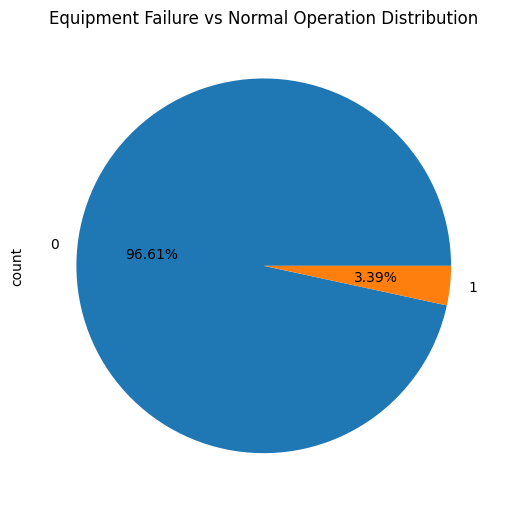

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Pie chart for failure distribution
plt.subplot(2, 3, 1)
maintenance_data['Target'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('Equipment Failure vs Normal Operation Distribution')
plt.tight_layout()
plt.show()

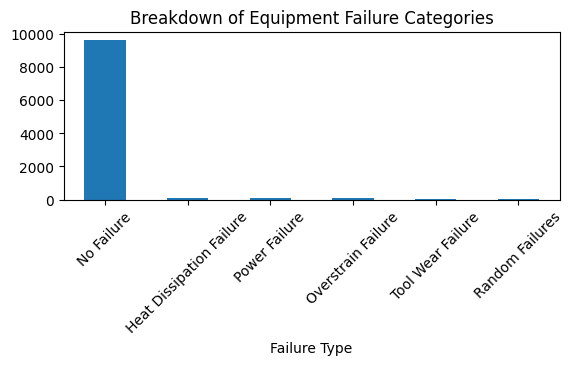

In [ ]:
# Display failure type breakdown
if 'Failure Type' in maintenance_data.columns:
    plt.subplot(2, 1, 2)
    maintenance_data['Failure Type'].value_counts().plot(kind='bar')
    plt.title('Breakdown of Equipment Failure Categories')
    plt.xticks(rotation=45)


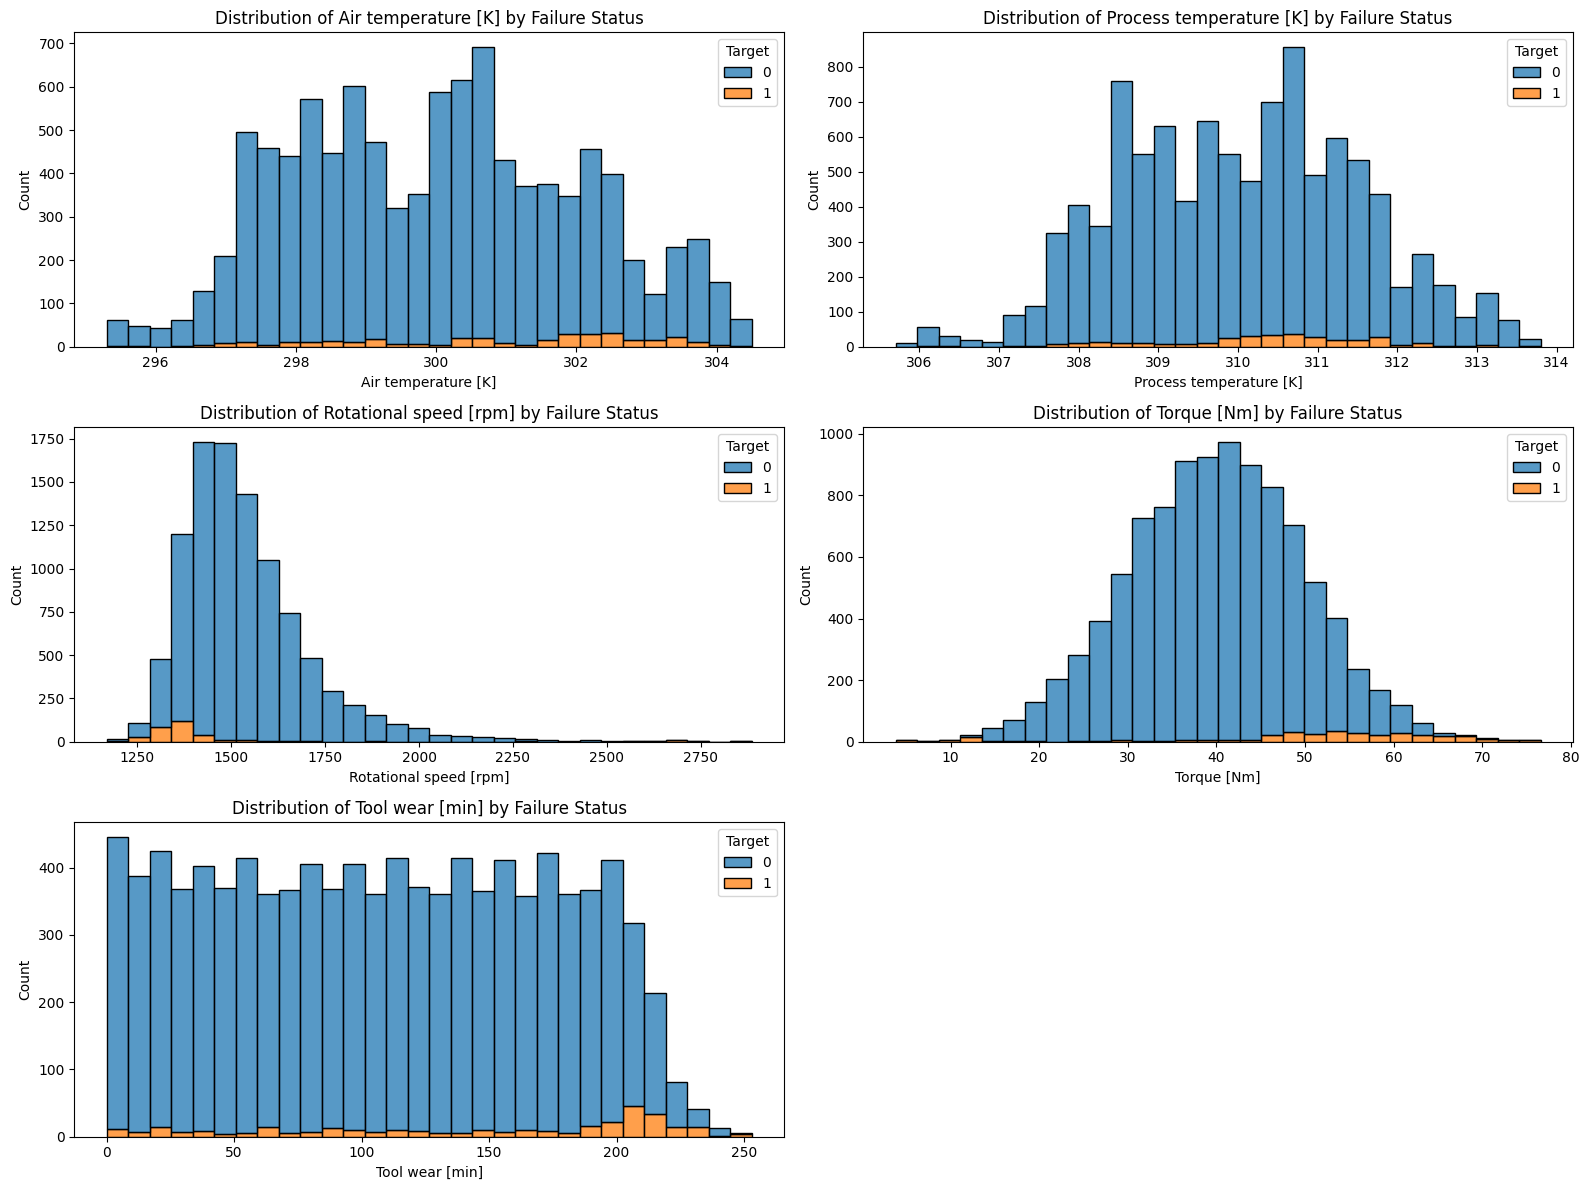

In [ ]:
# Sensor data analysis and visualization
plt.figure(figsize=(16, 12))
sensor_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Distribution plots for each sensor by failure status
for i, feature in enumerate(sensor_features, 1):
    plt.subplot(3, 2, i)
    maintenance_sns.histplot(data=maintenance_data, x=feature, hue='Target', multiple="stack", bins=30)
    plt.title(f'Distribution of {feature} by Failure Status')
plt.tight_layout()
plt.show()

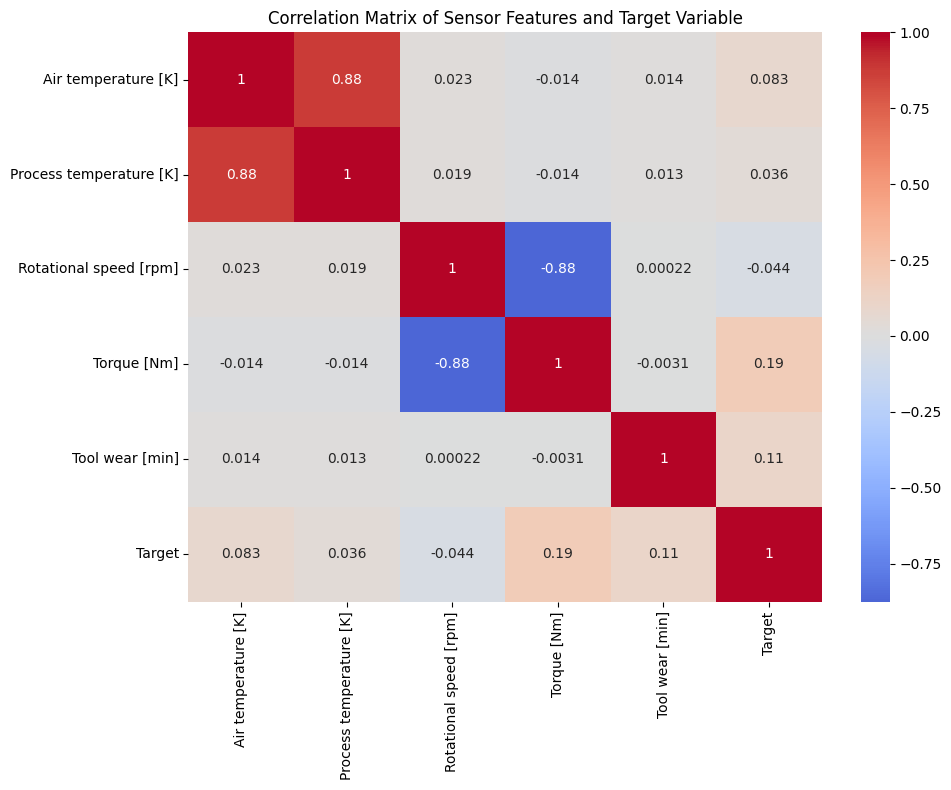

In [ ]:
# Correlation analysis between sensor variables
plt.figure(figsize=(10, 8))
correlation_features = sensor_features + ['Target']
maintenance_sns.heatmap(maintenance_data[correlation_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Sensor Features and Target Variable')
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

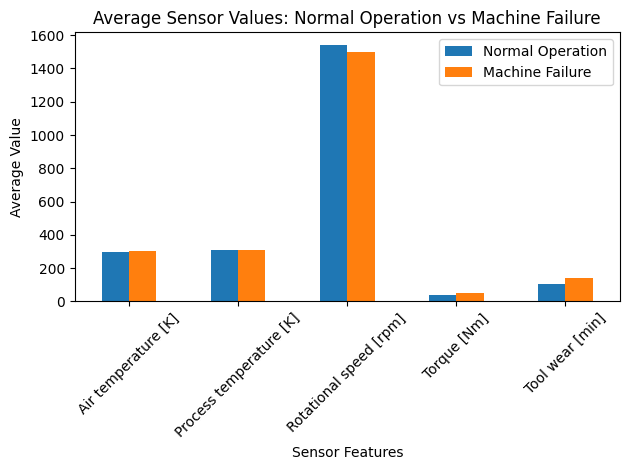

In [ ]:
# Average sensor values comparison between normal and failure cases
plt.figure(figsize=(14, 6))
feature_means_by_target = maintenance_data.groupby('Target')[sensor_features].mean()
feature_means_by_target.T.plot(kind='bar')
plt.title('Average Sensor Values: Normal Operation vs Machine Failure')
plt.xlabel('Sensor Features')
plt.ylabel('Average Value')
plt.legend(['Normal Operation', 'Machine Failure'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Class imbalance examination
print("\n=== CLASS IMBALANCE ANALYSIS ===")
target_counts = maintenance_data['Target'].value_counts()
print("Target variable distribution:")
print(f"Normal Operation (0): {target_counts[0]} samples ({target_counts[0]/len(maintenance_data)*100:.2f}%)")
print(f"Machine Failure (1): {target_counts[1]} samples ({target_counts[1]/len(maintenance_data)*100:.2f}%)")
print(f"Imbalance ratio: {target_counts[0]/target_counts[1]:.2f}:1")



=== CLASS IMBALANCE ANALYSIS ===
Target variable distribution:
Normal Operation (0): 9661 samples (96.61%)
Machine Failure (1): 339 samples (3.39%)
Imbalance ratio: 28.50:1


In [ ]:
# Feature selection and engineering for modeling
print("\n=== FEATURE ENGINEERING AND PREPROCESSING ===")

# Select relevant features for machine learning model
modeling_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Encode categorical product type variable
maintenance_data['Type_encoded'] = maintenance_data['Type'].map({'L': 0, 'M': 1, 'H': 2})
modeling_features.append('Type_encoded')

# Create feature matrix and target vector
X_features = maintenance_data[modeling_features]
y_target = maintenance_data['Target']

print("Selected features for predictive modeling:")
for idx, feature in enumerate(modeling_features, 1):
    print(f"{idx}. {feature}")


=== FEATURE ENGINEERING AND PREPROCESSING ===
Selected features for predictive modeling:
1. Air temperature [K]
2. Process temperature [K]
3. Rotational speed [rpm]
4. Torque [Nm]
5. Tool wear [min]
6. Type_encoded


In [ ]:
# Feature scaling using Min-Max normalization
maintenance_scaler = Maintenance_MinMaxScaler(feature_range=(0, 1))
X_scaled_features = maintenance_scaler.fit_transform(X_features)
X_scaled_features = maintenance_pd.DataFrame(X_scaled_features, columns=modeling_features)

# Clean and rename feature names to remove special characters for XGBoost compatibility
X_scaled_features.columns = X_scaled_features.columns.str.replace('[\[\]<>]', '', regex=True).str.replace(' ', '_')

# Update modeling_features list to reflect renamed columns
modeling_features = X_scaled_features.columns.tolist()

print("\nFeature scaling completed using Min-Max normalization")
print("Scaled feature summary statistics:")
print(X_scaled_features.describe().round(4))

# Dataset splitting for training and testing
X_train_set, X_test_set, y_train_set, y_test_set = Maintenance_train_test_split(
    X_scaled_features, y_target, test_size=0.2, random_state=2, stratify=y_target
)

print(f"\nDataset partitioning results:")
print(f"Training set dimensions: {X_train_set.shape}")
print(f"Testing set dimensions: {X_test_set.shape}")
print(f"Training target distribution: {y_train_set.value_counts().sort_index().values}")
print(f"Testing target distribution: {y_test_set.value_counts().sort_index().values}")



Feature scaling completed using Min-Max normalization
Scaled feature summary statistics:
       Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
count         10000.0000             10000.0000            10000.0000   
mean              0.5114                 0.5316                0.2158   
std               0.2174                 0.1832                0.1044   
min               0.0000                 0.0000                0.0000   
25%               0.3261                 0.3827                0.1484   
50%               0.5217                 0.5432                0.1950   
75%               0.6739                 0.6667                0.2584   
max               1.0000                 1.0000                1.0000   

        Torque_Nm  Tool_wear_min  Type_encoded  
count  10000.0000     10000.0000    10000.0000  
mean       0.4971         0.4267        0.2502  
std        0.1369         0.2516        0.3357  
min        0.0000         0.0000        0.0000  
25%    

In [ ]:
# SMOTE application for addressing class imbalance
print("\n=== SMOTE IMPLEMENTATION FOR CLASS BALANCING ===")
maintenance_smote = Maintenance_SMOTE(random_state=2, sampling_strategy='auto')
X_train_balanced, y_train_balanced = maintenance_smote.fit_resample(X_train_set, y_train_set)

print("SMOTE balancing results:")
print(f"Original training set shape: {X_train_set.shape}")
print(f"Balanced training set shape: {X_train_balanced.shape}")
print(f"Original class distribution: {y_train_set.value_counts().sort_index().values}")
print(f"Balanced class distribution: {y_train_balanced.value_counts().sort_index().values}")



=== SMOTE IMPLEMENTATION FOR CLASS BALANCING ===
SMOTE balancing results:
Original training set shape: (8000, 6)
Balanced training set shape: (15458, 6)
Original class distribution: [7729  271]
Balanced class distribution: [7729 7729]


Machine Learning Model Development and Training

In [ ]:
print("\n Random Forest Classifier Training and Optimization...")
rf_parameter_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

maintenance_rf_model = Maintenance_RandomForestClassifier(random_state=2, class_weight='balanced')
maintenance_rf_grid = Maintenance_GridSearchCV(
    estimator=maintenance_rf_model,
    param_grid=rf_parameter_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)
maintenance_rf_grid.fit(X_train_balanced, y_train_balanced)
best_rf_model = maintenance_rf_grid.best_estimator_

# Random Forest predictions and evaluation
y_pred_rf = best_rf_model.predict(X_test_set)
y_pred_proba_rf = best_rf_model.predict_proba(X_test_set)[:, 1]

rf_accuracy = accuracy_score(y_test_set, y_pred_rf)
rf_precision = precision_score(y_test_set, y_pred_rf)
rf_recall = recall_score(y_test_set, y_pred_rf)
rf_f1 = f1_score(y_test_set, y_pred_rf)

print(f"Random Forest Optimal Results:")
print(f"Best hyperparameters: {maintenance_rf_grid.best_params_}")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")



 Random Forest Classifier Training and Optimization...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Random Forest Optimal Results:
Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9595
Precision: 0.4488
Recall: 0.8382
F1-Score: 0.5846


In [ ]:
print("\nXGBoost Classifier Training and Optimization...")
xgb_parameter_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1.0]
}

maintenance_xgb_model = maintenance_xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=2,
    scale_pos_weight=len(y_train_balanced[y_train_balanced==0])/len(y_train_balanced[y_train_balanced==1])
)
maintenance_xgb_grid = Maintenance_GridSearchCV(
    estimator=maintenance_xgb_model,
    param_grid=xgb_parameter_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)
maintenance_xgb_grid.fit(X_train_balanced, y_train_balanced)
best_xgb_model = maintenance_xgb_grid.best_estimator_

# XGBoost predictions and evaluation
y_pred_xgb = best_xgb_model.predict(X_test_set)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test_set)[:, 1]

xgb_accuracy = accuracy_score(y_test_set, y_pred_xgb)
xgb_precision = precision_score(y_test_set, y_pred_xgb)
xgb_recall = recall_score(y_test_set, y_pred_xgb)
xgb_f1 = f1_score(y_test_set, y_pred_xgb)

print(f"XGBoost Optimal Results:")
print(f"Best hyperparameters: {maintenance_xgb_grid.best_params_}")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-Score: {xgb_f1:.4f}")



XGBoost Classifier Training and Optimization...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
XGBoost Optimal Results:
Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 0.9745
Precision: 0.5876
Recall: 0.8382
F1-Score: 0.6909


In [ ]:
print("\n Logistic Regression Training and Optimization...")
lr_parameter_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000, 2000]
}

maintenance_lr_model = Maintenance_LogisticRegression(random_state=2, class_weight='balanced')
maintenance_lr_grid = Maintenance_GridSearchCV(
    estimator=maintenance_lr_model,
    param_grid=lr_parameter_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)
maintenance_lr_grid.fit(X_train_balanced, y_train_balanced)
best_lr_model = maintenance_lr_grid.best_estimator_

# Logistic Regression predictions and evaluation
y_pred_lr = best_lr_model.predict(X_test_set)
y_pred_proba_lr = best_lr_model.predict_proba(X_test_set)[:, 1]

lr_accuracy = accuracy_score(y_test_set, y_pred_lr)
lr_precision = precision_score(y_test_set, y_pred_lr)
lr_recall = recall_score(y_test_set, y_pred_lr)
lr_f1 = f1_score(y_test_set, y_pred_lr)

print(f"Logistic Regression Optimal Results:")
print(f"Best hyperparameters: {maintenance_lr_grid.best_params_}")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")



 Logistic Regression Training and Optimization...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Logistic Regression Optimal Results:
Best hyperparameters: {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}
Accuracy: 0.8290
Precision: 0.1469
Recall: 0.8382
F1-Score: 0.2500


In [ ]:
print("\n Neural Network Architecture Design and Training...")

def create_maintenance_neural_network(input_dimensions):
    model = Maintenance_Sequential([
        Maintenance_Dense(128, activation='relu', input_shape=(input_dimensions,)),
        Maintenance_Dropout(0.3),
        Maintenance_Dense(64, activation='relu'),
        Maintenance_Dropout(0.2),
        Maintenance_Dense(32, activation='relu'),
        Maintenance_Dropout(0.1),
        Maintenance_Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Maintenance_Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model



 Neural Network Architecture Design and Training...


In [ ]:
# Neural network model training with early stopping
maintenance_nn_model = create_maintenance_neural_network(X_train_balanced.shape[1])
maintenance_early_stopping = Maintenance_EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

maintenance_nn_history = maintenance_nn_model.fit(
    X_train_balanced, y_train_balanced,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[maintenance_early_stopping],
    verbose=1
)

# Neural Network predictions and evaluation
y_pred_nn_proba = maintenance_nn_model.predict(X_test_set)
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int).ravel()

nn_accuracy = accuracy_score(y_test_set, y_pred_nn)
nn_precision = precision_score(y_test_set, y_pred_nn)
nn_recall = recall_score(y_test_set, y_pred_nn)
nn_f1 = f1_score(y_test_set, y_pred_nn)

print(f"Neural Network Results:")
print(f"Accuracy: {nn_accuracy:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")
print(f"F1-Score: {nn_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6995 - loss: 0.5790 - val_accuracy: 0.8357 - val_loss: 0.3734
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8684 - loss: 0.3132 - val_accuracy: 0.8952 - val_loss: 0.2702
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8853 - loss: 0.2797 - val_accuracy: 0.9059 - val_loss: 0.2554
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8859 - loss: 0.2656 - val_accuracy: 0.8781 - val_loss: 0.3204
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8953 - loss: 0.2556 - val_accuracy: 0.9146 - val_loss: 0.2539
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8991 - loss: 0.2410 - val_accuracy: 0.8590 - val_loss: 0.3502
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9017 - loss: 0.2388 - val_accuracy: 0.8632 - val_loss: 0.3336
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9026 - loss: 0.2328 - val_accu

In [ ]:
class MaintenanceWeightedEnsemble:
    def __init__(self, rf_model, xgb_model, lr_model, nn_model, weights=None):
        self.rf_model = rf_model
        self.xgb_model = xgb_model
        self.lr_model = lr_model
        self.nn_model = nn_model
        self.weights = weights if weights is not None else [0.25, 0.25, 0.25, 0.25]

    def predict_proba(self, X):
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]
        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        lr_predictions = self.lr_model.predict_proba(X)[:, 1]
        nn_predictions = self.nn_model.predict(X).ravel()

        # Calculate weighted average of all model predictions
        ensemble_predictions = (
            self.weights[0] * rf_predictions +
            self.weights[1] * xgb_predictions +
            self.weights[2] * lr_predictions +
            self.weights[3] * nn_predictions
        )

        return ensemble_predictions

    def predict(self, X, threshold=0.5):
        ensemble_predictions = self.predict_proba(X)
        return (ensemble_predictions > threshold).astype(int)

# Create weighted ensemble model instance
maintenance_ensemble_model = MaintenanceWeightedEnsemble(
    rf_model=best_rf_model,
    xgb_model=best_xgb_model,
    lr_model=best_lr_model,
    nn_model=maintenance_nn_model
)

# Ensemble model predictions and evaluation
y_pred_ensemble = maintenance_ensemble_model.predict(X_test_set)
y_pred_proba_ensemble = maintenance_ensemble_model.predict_proba(X_test_set)

ensemble_accuracy = accuracy_score(y_test_set, y_pred_ensemble)
ensemble_precision = precision_score(y_test_set, y_pred_ensemble)
ensemble_recall = recall_score(y_test_set, y_pred_ensemble)
ensemble_f1 = f1_score(y_test_set, y_pred_ensemble)

print("Weighted Averaging Ensemble Model Results:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"F1-Score: {ensemble_f1:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Weighted Averaging Ensemble Model Results:
Accuracy: 0.9585
Precision: 0.4444
Recall: 0.8824
F1-Score: 0.5911


Model Performance Metrics Comprehensive Comparison:
              Model  Accuracy  Precision  Recall  F1-Score
      Random Forest    0.9595     0.4488  0.8382    0.5846
            XGBoost    0.9745     0.5876  0.8382    0.6909
Logistic Regression    0.8290     0.1469  0.8382    0.2500
     Neural Network    0.9030     0.2520  0.9412    0.3975
  Weighted Ensemble    0.9585     0.4444  0.8824    0.5911


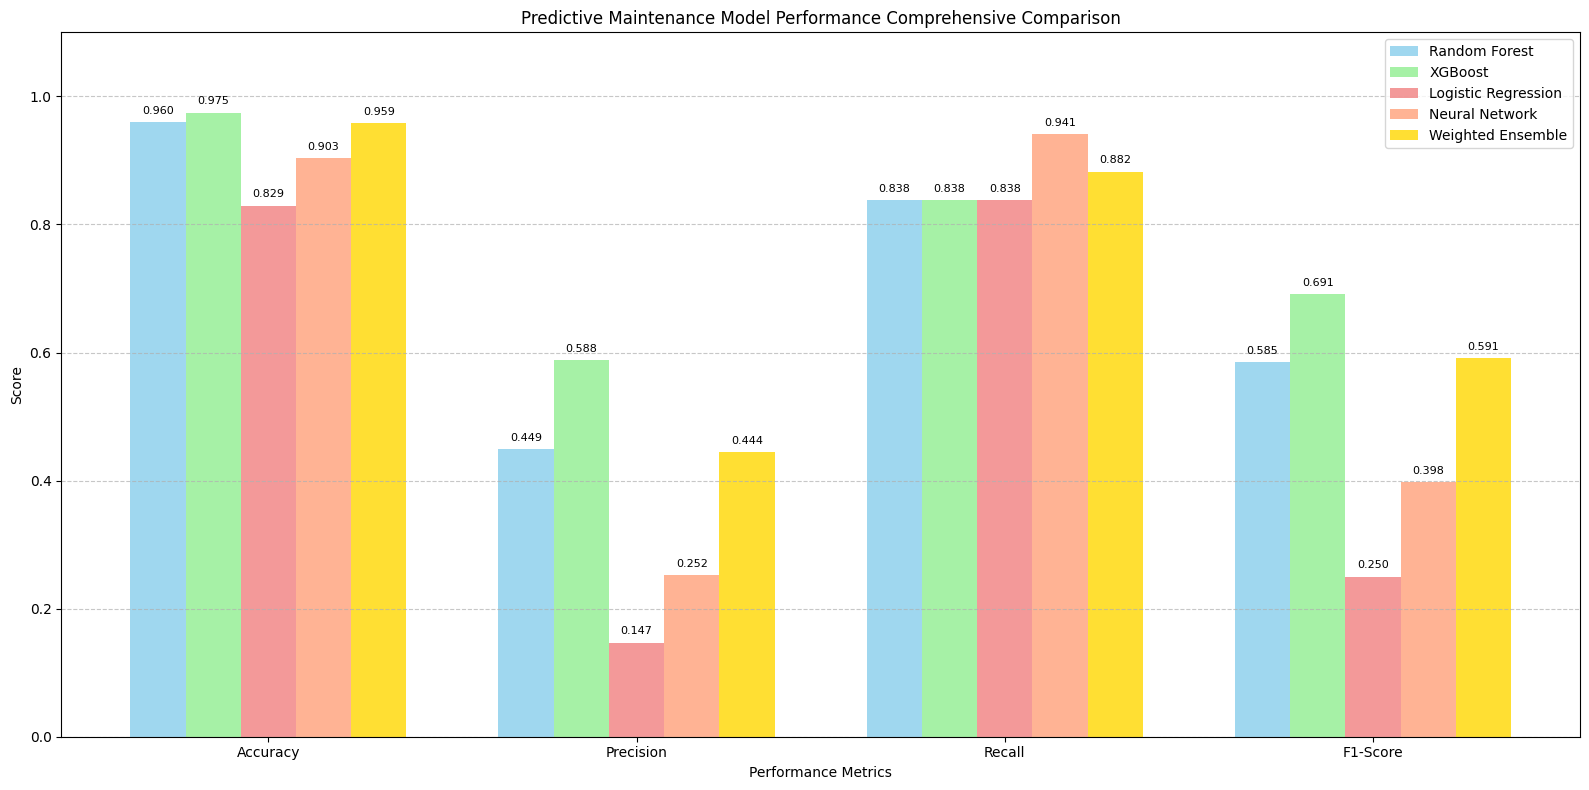

In [ ]:
# Create performance comparison dataframe
performance_comparison = {
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression', 'Neural Network', 'Weighted Ensemble'],
    'Accuracy': [rf_accuracy, xgb_accuracy, lr_accuracy, nn_accuracy, ensemble_accuracy],
    'Precision': [rf_precision, xgb_precision, lr_precision, nn_precision, ensemble_precision],
    'Recall': [rf_recall, xgb_recall, lr_recall, nn_recall, ensemble_recall],
    'F1-Score': [rf_f1, xgb_f1, lr_f1, nn_f1, ensemble_f1]
}

performance_df = maintenance_pd.DataFrame(performance_comparison)
print("Model Performance Metrics Comprehensive Comparison:")
print(performance_df.round(4).to_string(index=False))

# Visualization of model performance comparison
plt.figure(figsize=(16, 8))
metrics_for_visualization = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
bar_width = 0.15
index_positions = maintenance_np.arange(len(metrics_for_visualization))

model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Neural Network', 'Weighted Ensemble']
color_palette = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'gold']

for i, model in enumerate(model_names):
    metric_values = [performance_comparison[metric][i] for metric in metrics_for_visualization]
    plt.bar(index_positions + i * bar_width, metric_values, bar_width,
           label=model, alpha=0.8, color=color_palette[i])

plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Predictive Maintenance Model Performance Comprehensive Comparison')
plt.xticks(index_positions + bar_width * 2, metrics_for_visualization)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.1)

# Add value labels on bars
for i, model in enumerate(model_names):
    metric_values = [performance_comparison[metric][i] for metric in metrics_for_visualization]
    for j, value in enumerate(metric_values):
        plt.text(j + i * bar_width, value + 0.01, f'{value:.3f}',
                ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()



=== CONFUSION MATRIX ANALYSIS ===


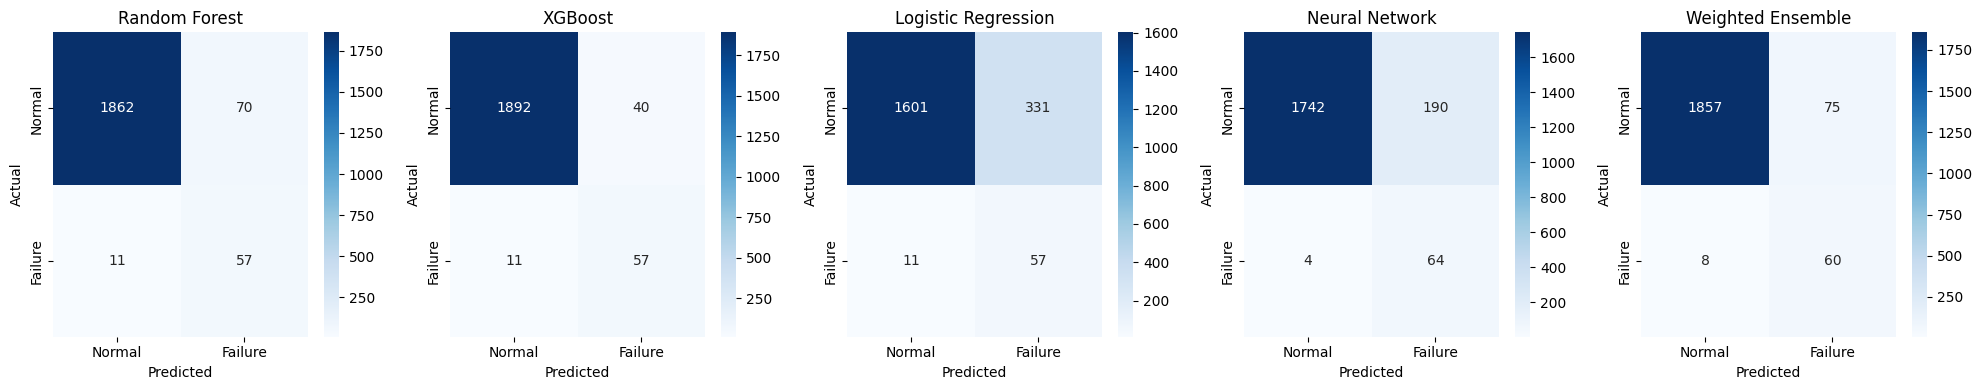

In [ ]:
print("\n=== CONFUSION MATRIX ANALYSIS ===")

plt.figure(figsize=(20, 4))
all_predictions = [y_pred_rf, y_pred_xgb, y_pred_lr, y_pred_nn, y_pred_ensemble]
model_titles = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Neural Network', 'Weighted Ensemble']

for i, (predictions, title) in enumerate(zip(all_predictions, model_titles)):
    plt.subplot(1, 5, i+1)
    cm = confusion_matrix(y_test_set, predictions)
    maintenance_sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                           xticklabels=['Normal', 'Failure'],
                           yticklabels=['Normal', 'Failure'])
    plt.title(f'{title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()



=== FEATURE IMPORTANCE ANALYSIS ===
Random Forest Feature Importance Ranking:
Torque_Nm: 0.3015
Rotational_speed_rpm: 0.2944
Tool_wear_min: 0.2181
Air_temperature_K: 0.1026
Process_temperature_K: 0.0679
Type_encoded: 0.0155

XGBoost Feature Importance Ranking:
Rotational_speed_rpm: 0.3519
Torque_Nm: 0.2712
Tool_wear_min: 0.1935
Air_temperature_K: 0.0752
Type_encoded: 0.0556
Process_temperature_K: 0.0526


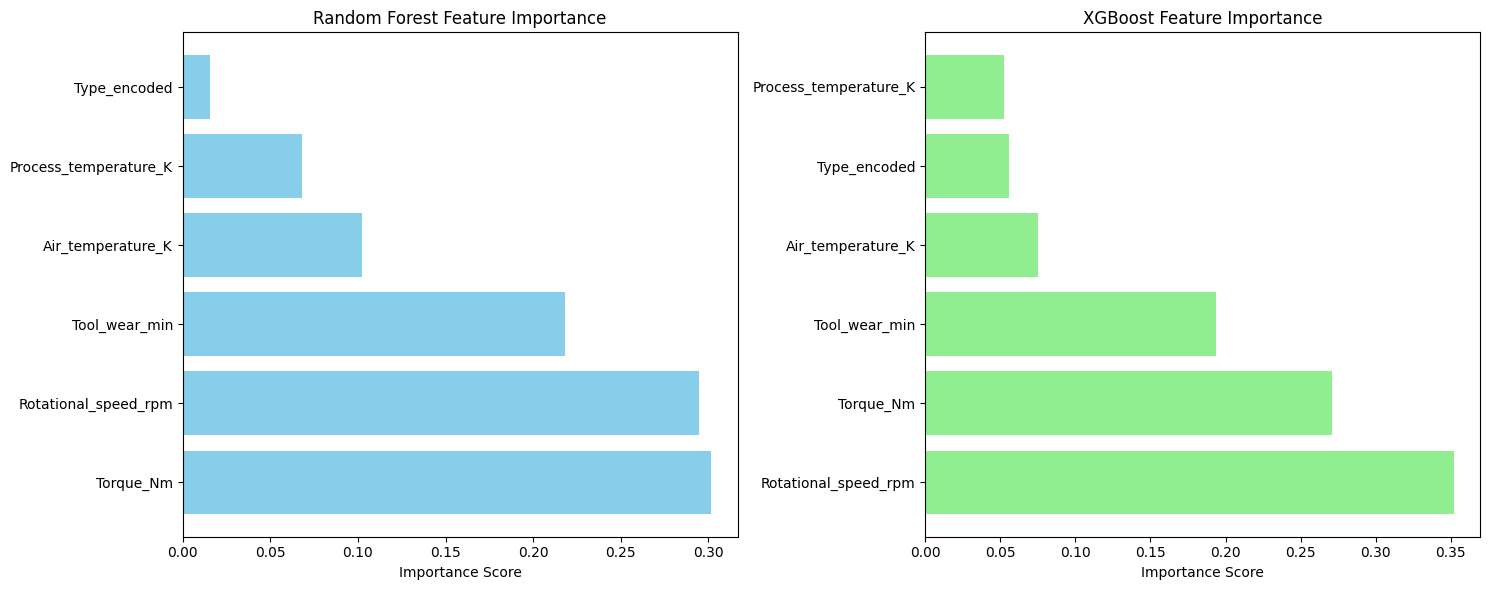

In [ ]:
# Feature Importance Analysis
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# Random Forest feature importance
rf_feature_importance = best_rf_model.feature_importances_
rf_importance_ranking = list(zip(modeling_features, rf_feature_importance))
rf_importance_ranking.sort(key=lambda x: x[1], reverse=True)

print("Random Forest Feature Importance Ranking:")
for feature, importance in rf_importance_ranking:
    print(f"{feature}: {importance:.4f}")

# XGBoost feature importance
xgb_feature_importance = best_xgb_model.feature_importances_
xgb_importance_ranking = list(zip(modeling_features, xgb_feature_importance))
xgb_importance_ranking.sort(key=lambda x: x[1], reverse=True)

print("\nXGBoost Feature Importance Ranking:")
for feature, importance in xgb_importance_ranking:
    print(f"{feature}: {importance:.4f}")

# Feature importance visualization
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
rf_features = [x[0] for x in rf_importance_ranking]
rf_importance_values = [x[1] for x in rf_importance_ranking]
plt.barh(rf_features, rf_importance_values, color='skyblue')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')

plt.subplot(1, 2, 2)
xgb_features = [x[0] for x in xgb_importance_ranking]
xgb_importance_values = [x[1] for x in xgb_importance_ranking]
plt.barh(xgb_features, xgb_importance_values, color='lightgreen')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')

plt.tight_layout()
plt.show()


In [ ]:
# Actionable Maintenance Recommendations System
print("\n=== ACTIONABLE MAINTENANCE RECOMMENDATIONS SYSTEM ===")

def generate_maintenance_recommendations(model, X_sample, feature_names, threshold=0.5):
    """
    Generate specific maintenance recommendations based on failure risk predictions
    """
    failure_risk_scores = model.predict_proba(X_sample)
    maintenance_recommendations = []

    for i, risk_score in enumerate(failure_risk_scores):
        equipment_id = f"EQUIP_{i+1:04d}"

        if risk_score > 0.8:
            priority_level = "CRITICAL"
            recommended_action = "Immediate shutdown and emergency maintenance required"
            timeline = "Within 4 hours"
        elif risk_score > 0.6:
            priority_level = "HIGH"
            recommended_action = "Schedule urgent maintenance intervention"
            timeline = "Within 24 hours"
        elif risk_score > 0.4:
            priority_level = "MEDIUM"
            recommended_action = "Plan preventive maintenance"
            timeline = "Within 72 hours"
        elif risk_score > 0.2:
            priority_level = "LOW"
            recommended_action = "Enhanced monitoring recommended"
            timeline = "Within 1 week"
        else:
            priority_level = "NORMAL"
            recommended_action = "Continue standard operation"
            timeline = "Follow regular schedule"

        maintenance_recommendations.append({
            'Equipment_ID': equipment_id,
            'Failure_Risk_Score': risk_score,
            'Priority_Level': priority_level,
            'Recommended_Action': recommended_action,
            'Action_Timeline': timeline
        })

    return maintenance_recommendations

# Generate sample maintenance recommendations using ensemble model
sample_equipment_data = X_test_set.head(10)
maintenance_recommendations = generate_maintenance_recommendations(
    maintenance_ensemble_model, sample_equipment_data, modeling_features
)

print("Sample Equipment Maintenance Recommendations:")
print("="*90)
for recommendation in maintenance_recommendations:
    print(f"Equipment ID: {recommendation['Equipment_ID']}")
    print(f"Failure Risk Score: {recommendation['Failure_Risk_Score']:.3f}")
    print(f"Priority Level: {recommendation['Priority_Level']}")
    print(f"Recommended Action: {recommendation['Recommended_Action']}")
    print(f"Action Timeline: {recommendation['Action_Timeline']}")
    print("-"*50)

# Key Research Findings and Insights
print("\n=== KEY RESEARCH FINDINGS AND INSIGHTS ===")

# Identify best performing model
best_model_index = performance_df['F1-Score'].idxmax()
best_performing_model = performance_df.iloc[best_model_index]['Model']
highest_f1_score = performance_df.iloc[best_model_index]['F1-Score']

print(f"Best Performing Model: {best_performing_model}")
print(f"Highest F1-Score Achieved: {highest_f1_score:.4f}")

print(f"\nTop 3 Most Predictive Sensor Indicators (Random Forest):")
for i, (feature, importance) in enumerate(rf_importance_ranking[:3], 1):
    print(f"{i}. {feature}: {importance:.4f}")

print(f"\nTop 3 Most Predictive Sensor Indicators (XGBoost):")
for i, (feature, importance) in enumerate(xgb_importance_ranking[:3], 1):
    print(f"{i}. {feature}: {importance:.4f}")

print(f"\nClass Imbalance Handling Effectiveness:")
print(f"Original imbalance ratio: {target_counts[0]/target_counts[1]:.2f}:1")
print(f"SMOTE successfully balanced the training dataset for improved learning")

print(f"\nEnsemble Method Performance Benefits:")
ensemble_improvement = ensemble_f1 - max(rf_f1, xgb_f1, lr_f1, nn_f1)
print(f"Ensemble F1-Score improvement over best individual model: {ensemble_improvement:.4f}")

if ensemble_improvement > 0:
    print("Ensemble method successfully improved prediction performance")
else:
    print("Ensemble method did not improve over best individual model")



=== ACTIONABLE MAINTENANCE RECOMMENDATIONS SYSTEM ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sample Equipment Maintenance Recommendations:
Equipment ID: EQUIP_0001
Failure Risk Score: 0.149
Priority Level: NORMAL
Recommended Action: Continue standard operation
Action Timeline: Follow regular schedule
--------------------------------------------------
Equipment ID: EQUIP_0002
Failure Risk Score: 0.037
Priority Level: NORMAL
Recommended Action: Continue standard operation
Action Timeline: Follow regular schedule
--------------------------------------------------
Equipment ID: EQUIP_0003
Failure Risk Score: 0.009
Priority Level: NORMAL
Recommended Action: Continue standard operation
Action Timeline: Follow regular schedule
--------------------------------------------------
Equipment ID: EQUIP_0004
Failure Risk Score: 0.005
Priority Level: NORMAL
Recommended Action: Continue standard operation
Action Timeline: Follow regular schedule
--------------------------------------------------
Equip